<a href="https://colab.research.google.com/github/ayulockin/DLshots/blob/master/Intro_to_covolutional_neural_network_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setups, Imports and Installations

In [ ]:
%%capture
!pip install wandb -q

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Download Dataset and Prepare Dataloader

In [ ]:
BATCH_SIZE = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

CLASS_NAMES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Visualize Data

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      img = image_batch[n] / 2 + 0.5     # unnormalize
      img = img.numpy()
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.title(CLASS_NAMES[label_batch[n]])
      plt.axis('off')

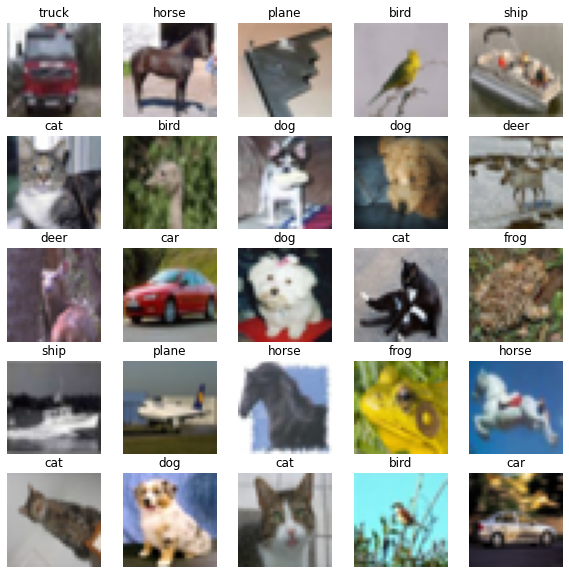

In [ ]:
sample_images, sample_labels = next(iter(trainloader))
show_batch(sample_images, sample_labels)

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Train Step


In [ ]:
def train(model, device, train_loader, optimizer, criterion, epoch, steps_per_epoch=20):
  # Switch model to training mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
  model.train()

  train_loss = 0
  train_total = 0
  train_correct = 0

  # We loop over the data iterator, and feed the inputs to the network and adjust the weights.
  for batch_idx, (data, target) in enumerate(train_loader, start=0):
    
    # Load the input features and labels from the training dataset
    data, target = data.to(device), target.to(device)
    
    # Reset the gradients to 0 for all learnable weight parameters
    optimizer.zero_grad()
    
    # Forward pass: Pass image data from training dataset, make predictions about class image belongs to (0-9 in this case)
    output = model(data)
    
    # Define our loss function, and compute the loss
    loss = criterion(output, target)
    train_loss += loss.item()

    scores, predictions = torch.max(output.data, 1)
    train_total += target.size(0)
    train_correct += int(sum(predictions == target))
            
    # Reset the gradients to 0 for all learnable weight parameters
    optimizer.zero_grad()

    # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
    loss.backward()
    
    # Update the neural network weights
    optimizer.step()

  acc = round((train_correct / train_total) * 100, 2)
  print('Epoch [{}], Loss: {}, Accuracy: {}'.format(epoch, train_loss/train_total, acc), end='')
  wandb.log({'Train Loss': train_loss/train_total, 'Train Accuracy': acc, 'Epoch': epoch})
  

# Test Step


In [ ]:
def test(model, device, test_loader, criterion, epoch, classes):
  # Switch model to evaluation mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
  model.eval()

  test_loss = 0
  test_total = 0
  test_correct = 0

  example_images = []
  with torch.no_grad():
      for data, target in test_loader:
          # Load the input features and labels from the test dataset
          data, target = data.to(device), target.to(device)
          
          # Make predictions: Pass image data from test dataset, make predictions about class image belongs to (0-9 in this case)
          output = model(data)
          
          # Compute the loss sum up batch loss
          test_loss += criterion(output, target).item()
          
          scores, predictions = torch.max(output.data, 1)
          test_total += target.size(0)
          test_correct += int(sum(predictions == target))

  acc = round((test_correct / test_total) * 100, 2)
  print(' Test_loss: {}, Test_accuracy: {}'.format(test_loss/test_total, acc))
  wandb.log({'Test Loss': test_loss/test_total, 'Test Accuracy': acc, 'Epoch': epoch})

# Initialize Model

In [ ]:
net = Net().to(device)
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Train

In [ ]:
wandb.init(entity='authors', project='seo')
wandb.watch(net, log='all')

for epoch in range(10):
  train(net, device, trainloader, optimizer, criterion, epoch)
  test(net, device, testloader, criterion, epoch, CLASS_NAMES)

print('Finished Training')

Epoch [0], Loss: 0.05086672699689865, Accuracy: 40.48 Test_loss: 0.04320901259183884, Test_accuracy: 50.6
Epoch [1], Loss: 0.041145119889974595, Accuracy: 53.07 Test_loss: 0.03815367004275322, Test_accuracy: 56.26
Epoch [2], Loss: 0.03699324751853943, Accuracy: 58.09 Test_loss: 0.036491077208518984, Test_accuracy: 58.4
Epoch [3], Loss: 0.03448544403076172, Accuracy: 60.97 Test_loss: 0.035059598845243456, Test_accuracy: 60.21
Epoch [4], Loss: 0.03252055426180363, Accuracy: 63.03 Test_loss: 0.03386568157076836, Test_accuracy: 61.32
Epoch [5], Loss: 0.03122256977021694, Accuracy: 64.61 Test_loss: 0.03502647889852524, Test_accuracy: 61.25
Epoch [6], Loss: 0.029937799527645113, Accuracy: 66.02 Test_loss: 0.0339851944744587, Test_accuracy: 61.76
Epoch [7], Loss: 0.02871934347450733, Accuracy: 67.43 Test_loss: 0.03346726112961769, Test_accuracy: 62.74
Epoch [8], Loss: 0.027809378865361212, Accuracy: 68.61 Test_loss: 0.03427882898449898, Test_accuracy: 61.91
Epoch [9], Loss: 0.0268102982383966